## Classification models for heart disease predicting

### Import libraries ...

In [48]:
# import the library
%matplotlib inline

import pandas as pnd
import numpy as nmp
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# sklearn :: models
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set_style('whitegrid')

## Load data set

In [49]:
df_clv = pnd.read_csv('C:\\Users\\hbenamor\\Desktop\\uc-heartdisease-datafolder\\processed.cleveland.data', header = None)
df_hds = df_clv
# rename columns since the file does not contain names.
df_hds.columns=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "goal"]
print(df_hds.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'goal'],
      dtype='object')


In [50]:
# Some 'goal' values exceed 1 whereas they ar assumed to be either 0 or 1. They are set back to 1.
# 'thal' and 'ca' have bad values '?'. They are set to default "no issue" values for each.
df_hds["goal"] = nmp.where(df_hds['goal'] >= 1, 1, df_hds['goal']) 
df_hds["ca"] = nmp.where(df_hds['ca']=='?', '0.0', df_hds['ca'])
df_hds["thal"] = nmp.where(df_hds['thal']=='?', '3.0', df_hds['thal'])

In [51]:
# the 2 variables 'thal and 'ca' are categorical and need to be transformed into numeric.
df_hds["thal"] = pnd.to_numeric(df_hds['thal'])
df_hds["ca"] = pnd.to_numeric(df_hds['ca'])

In [52]:
df_hds.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,goal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [53]:
df_hds.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,goal
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,0.0,3.0,0


### Feature engineering

In [54]:
# 'sex' is useless
df_sex = pd.get_dummies(df_hds['sex'])
df_sex.columns = ['male', 'female']
df_hds = pd.concat([df_sex, df_hds], axis=1)
del df_hds['sex']
df_hds.head()

,male,female,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,goal
0,0,1,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,0,1,67.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,0,1,67.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,0,1,37.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,1,0,41.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [55]:
# feature engineering
X_columns = df_hds.columns[:-1]
y_column  = df_hds.columns[-1]

### Model training - split data

In [56]:
# split data
threshold = 0.85
X = df_hds[X_columns]
y = df_hds[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (257, 14)
y_train (257,)
X_test (46, 14)
y_test (46,)


### Model training - use various models

In [57]:
models = [
    ('Naive Bayes', GaussianNB()),
    ('RandomForestClassifier10', RandomForestClassifier(n_estimators=10)),
    ('RandomForestClassifier100', RandomForestClassifier(n_estimators=100)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier())
]
results = []
for m in models:
    print('MODEL', m[0])
    model = m[1]
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test).round()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(confusion_matrix(y_test, y_pred))
    print('Precision', precision)
    print('Recall', recall)
    results.append([m[0], precision, recall])
    
    # if there is a feature importance, print top 5
    importance = []
    if hasattr(model, 'feature_importances_'):
        print('Feature Importance')
        importance = []
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.feature_importances_[i]])
        print(pnd.DataFrame(importance).sort_values(by=1, ascending=False).head())
    elif hasattr(model, 'coef_'):
        print('Feature Importance')
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.coef_[i]])
        print(pnd.DataFrame(importance).sort_values(by=1, ascending=False).head())
        
    print('')

# sort the results and print as a table
df_results = pnd.DataFrame(results)
df_results.columns = ['model', 'precision', 'recall']
df_results = df_results.sort_values(by='precision', ascending=False)
df_results

MODEL Naive Bayes
[[17  9]
 [ 4 16]]
Precision 0.64
Recall 0.8

MODEL RandomForestClassifier10
[[18  8]
 [ 3 17]]
Precision 0.68
Recall 0.85
Feature Importance
          0         1
13     thal  0.171075
10  oldpeak  0.164267
12       ca  0.108149
5      chol  0.107723
2       age  0.091550

MODEL RandomForestClassifier100
[[18  8]
 [ 4 16]]
Precision 0.6666666666666666
Recall 0.8
Feature Importance
          0         1
13     thal  0.147933
10  oldpeak  0.122344
12       ca  0.109761
3        cp  0.097632
2       age  0.088160

MODEL KNeighborsClassifier
[[21  5]
 [ 6 14]]
Precision 0.7368421052631579
Recall 0.7

MODEL DecisionTreeClassifier
[[15 11]
 [ 6 14]]
Precision 0.56
Recall 0.7
Feature Importance
          0         1
13     thal  0.333902
2       age  0.112154
10  oldpeak  0.105848
9     exang  0.101660
12       ca  0.085831



,model,precision,recall
3,KNeighborsClassifier,0.736842,0.70
1,RandomForestClassifier10,0.680000,0.85
2,RandomForestClassifier100,0.666667,0.80
0,Naive Bayes,0.640000,0.80
4,DecisionTreeClassifier,0.560000,0.70


### Model training - cross validation

In [58]:
models = [
    ('Naive Bayes', GaussianNB()),
    ('RandomForestClassifier10', RandomForestClassifier(n_estimators=10)),
    ('RandomForestClassifier100', RandomForestClassifier(n_estimators=100)),
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier())
]

k = 10
results = {}
for m in models:
    print('MODEL', m[0])
    results[m[0]] = {'precision':[], 'recall':[]}
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model = m[1]
        model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test).round()
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        results[m[0]]['precision'].append(precision)
        results[m[0]]['recall'].append(recall)

MODEL Naive Bayes
MODEL RandomForestClassifier10
MODEL RandomForestClassifier100
MODEL KNeighborsClassifier
MODEL DecisionTreeClassifier


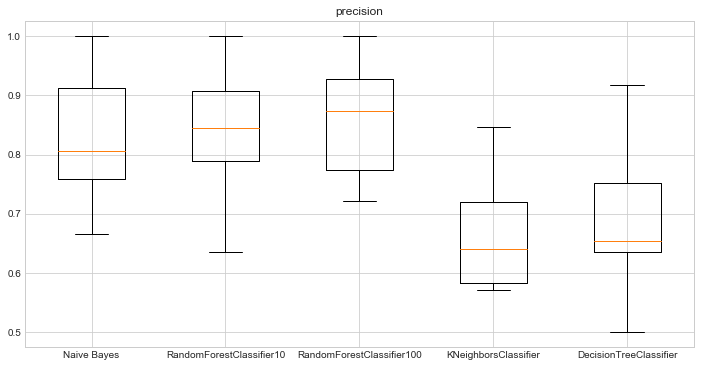

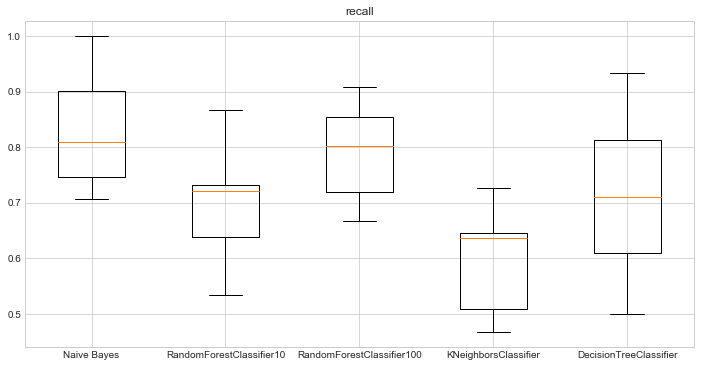

In [59]:
# Evaluation
for metric in ['precision', 'recall']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
    plt.show()

Cross validation improved the precision ... 

Age appeared ... compare feature importance!

Comments and analysis TBC ...